# BP神经网络预测

In [1]:
# 导入包
import torch
from torch import nn
import numpy as np
import torch.nn.functional as Fun
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据

In [2]:
file_name = "data.mat"
data = scio.loadmat(file_name)
x = data.get("pop1")
x = x.T
x = x/x.max(0)
y = data.get("tot1")
# y_min = y.min
y = y[0]

In [3]:
print("x.shape :", x.shape, " y.shape: ", y.shape)

x.shape : (205, 4)  y.shape:  (205,)


In [4]:
print(x[0:5])

[[ 0.79444444  0.81403509  0.99458484 -0.71351873]
 [ 0.86944444  0.61052632  0.89891697 -0.64333713]
 [ 0.79166667  0.76842105  0.96119134  0.09598601]
 [ 0.78333333  0.74736842  0.95036101  0.30164549]
 [ 0.85833333  0.70877193  0.98736462 -0.04381086]]


In [5]:
print(y[0:5])

[4.6 6.6 9.1 5.1 5.3]


In [6]:
def split_train_test(X, y, test_ratio):
    shuffled_indices = np.random.permutation(len(y))
    test_set_size = int(len(y) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return X[train_indices,:], y[train_indices], X[test_indices,:], y[test_indices]

In [7]:
train_x, train_y, test_x, test_y = split_train_test(x, y, 0.2)

In [8]:
train_x.shape, train_y.shape,test_x.shape, test_y.shape

((164, 4), (164,), (41, 4), (41,))

## 将numy转换为tensor

In [9]:
train_x = torch.FloatTensor(train_x)
train_y = torch.FloatTensor(train_y)
test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y)

dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_iter = torch.utils.data.DataLoader(dataset, 10,shuffle=True)

## 定义BP神经网络

In [10]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, X_data):
        x = self.hidden(X_data)
        x = Fun.relu(x)
        predict_y = self.out(x)
        return predict_y

In [11]:
net = Net(4, 9, 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.025)
loss = torch.nn.MSELoss()
for param in net.parameters():
    torch.nn.init.normal_(param, mean=0, std=0.01)
print(net)

Net(
  (hidden): Linear(in_features=4, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=1, bias=True)
)


In [12]:
train_ls = []
for i in range(500):
    for x, y in train_iter:
        out = net(x)
        l = loss(out, train_y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    train_ls.append(l)

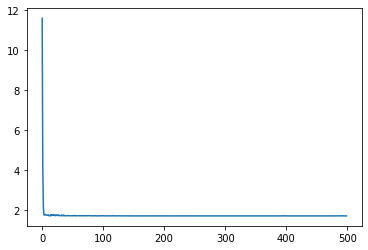

In [13]:
plt.plot(train_ls)
plt.show()

In [14]:
predict_y = net(train_x)
predict_y[0:5]

tensor([[6.0211],
        [6.0202],
        [6.0219],
        [6.0201],
        [6.0148]], grad_fn=<SliceBackward>)

In [15]:
for parameters in net.parameters():
    print(parameters)

Parameter containing:
tensor([[-0.1202, -0.1257, -0.1187,  0.0771],
        [-0.1447, -0.1537, -0.1401,  0.1365],
        [-0.1345, -0.1126, -0.1325,  0.0712],
        [ 0.0715,  0.0494,  0.1371, -0.0269],
        [-0.1281, -0.1278, -0.1377,  0.1632],
        [-0.1296, -0.1690, -0.1421, -0.1404],
        [ 0.0692,  0.0820,  0.1046, -0.0525],
        [ 0.1041,  0.0601,  0.1189, -0.0422],
        [-0.0043, -0.0078, -0.0012, -0.0032]], requires_grad=True)
Parameter containing:
tensor([ 1.4591, -0.1564,  1.4884,  1.5172, -0.1453, -0.1544,  1.4854,  1.5192,
        -0.0098], requires_grad=True)
Parameter containing:
tensor([[0.5681, 0.1471, 0.5867, 0.6791, 0.1419, 0.1463, 0.6719, 0.6840, 0.0158]],
       requires_grad=True)
Parameter containing:
tensor([1.1457], requires_grad=True)


In [16]:
# clarke网格误差分析
def clarke(y,y_predicted):
    """
    clarke网格分析

    total, percentage = clarke(y, yp)
    
    INPUTS:
    y       Reference values(血糖浓度参考值)
    yp      Predicted/estimated values(血糖预测值)
    
    OUTPUTS:

    """
    # 设置坐标轴范围和坐标轴名称
    plt.xlim(0, 400*0.0556)
    plt.ylim(0, 400*0.0556)
    plt.xlabel('Reference values of Blood Glucose(mmol/L)')
    plt.ylabel('Predicted values of Blood Glucose(mmol/L)')
    # 获取数据长度
    n = len(y)
    # 散点图绘制数据
    plt.scatter(y, y_predicted, s=15)
    # 绘制网线
    # 上半区网线
    plt.plot([0,400*0.0556],[0,400*0.0556],linestyle=':',c='k') 
    plt.plot([0,175*0.0556/3],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([175*0.0556/3,400*0.0556/1.2],[70*0.0556,400*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,70*0.0556],[84*0.0556,400*0.0556],c='k', linewidth=1)
    plt.plot([0,70*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,290*0.0556],[180*0.0556,400*0.0556],c='k', linewidth=1)
    # 下半区网线绘制
    plt.plot([70*0.0556,70*0.0556],[0,56*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,400*0.0556],[56*0.0556,320*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,400*0.0556],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,240*0.0556],[70*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,400*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([130*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    
    # 绘制区域标签A,B,C,D,E
    plt.text(30*0.0556,20*0.0556,'A',fontsize=9);
    plt.text(30*0.0556,150*0.0556,'D',fontsize=9);
    plt.text(30*0.0556,380*0.0556,'E',fontsize=9);
    plt.text(150*0.0556,380*0.0556,'C',fontsize=9);
    plt.text(160*0.0556,20*0.0556,'C',fontsize=9);
    plt.text(380*0.0556,20*0.0556,'E',fontsize=9);
    plt.text(380*0.0556,120*0.0556,'D',fontsize=9);
    plt.text(380*0.0556,260*0.0556,'B',fontsize=9);
    plt.text(280*0.0556,380*0.0556,'B',fontsize=9);

    # 计算数据
    total = np.zeros(5)
    # A区域
    for i in range(0,n):
        if (y[i] <= 70*0.0556 and y_predicted[i] <= 70*0.0556) or (y_predicted[i] <= 1.2*y[i] and y_predicted[i] >= 0.8*y[i]): 
            total[0] = total[0] + 1
        else:
            # E区域
            if(y[i] >= 180*0.0556 and y_predicted[i] <= 70*0.0556) or (y[i] <= 70*0.0556 and y_predicted[i] >= 180*0.0556):
                total[4] = total[4] + 1
            else:
                # 区域C
                if (y[i] >= 70*0.0556 and y[i] <= 290*0.0556) and (y_predicted[i] >= y[i] + 110*0.0556) or (y[i] >= 130*0.0556 and y[i] <= 180*0.0556) and (y_predicted[i] <= (7/5)*y[i] - 182*0.0556):
                    total[2] = total[2] + 1
                else:
                    # 区域D
                    if (y[i] >= 240*0.0556) and (y_predicted[i] >= 70*0.0556) and (y_predicted[i] <= 180*0.0556) or (y[i] <= 175*0.0556/3 and y_predicted[i] <= 180*0.0556) and (y_predicted[i] >= 70*0.0556) or (y[i] >= 175*0.0556/3 and y[i] <= 70*0.0556) and (y_predicted[i] >= (6/5)*y[i]):
                        total[3] = total[3] + 1
                    else:
                        # 区域B
                        total[1] = total[1] + 1

    percentage = (total/n)*100
    plt.show()
    return total, percentage

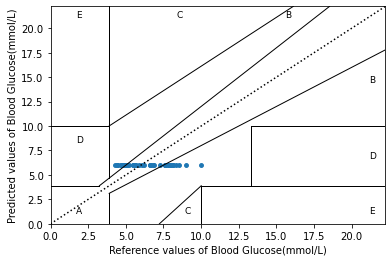

In [17]:
predict_y = net(test_x).detach().numpy()
test_y = (test_y).numpy()
total, percentage = clarke(test_y, predict_y)

In [18]:
print(test_y)

[ 4.7  5.1  8.5  7.6  4.8  8.   6.9  6.1  6.7  8.1  7.9  5.   7.3  6.6
  5.5  7.6  5.5  4.8  5.7  4.4  8.3  5.9  5.2  8.1  7.8  6.6  4.8  5.
  5.1  5.6  6.8 10.   6.2  4.5  4.7  4.4  4.8  7.6  9.   7.8  4.3]


In [19]:
print(predict_y)

[[6.014335 ]
 [6.0129666]
 [6.0203032]
 [6.01732  ]
 [6.0236425]
 [6.019033 ]
 [6.01561  ]
 [6.023127 ]
 [6.0249643]
 [6.018068 ]
 [6.021645 ]
 [6.0216784]
 [6.016699 ]
 [6.0177016]
 [6.021483 ]
 [6.0234876]
 [6.0210032]
 [6.0113306]
 [6.023558 ]
 [6.0198455]
 [6.0230975]
 [6.0206695]
 [6.02142  ]
 [6.0201173]
 [6.019656 ]
 [6.0209274]
 [6.02255  ]
 [6.0188737]
 [6.024201 ]
 [6.021982 ]
 [6.022196 ]
 [6.022723 ]
 [6.0249715]
 [6.013415 ]
 [6.021832 ]
 [6.0222206]
 [6.0214167]
 [6.0185847]
 [6.023324 ]
 [6.0228963]
 [6.0256352]]


In [20]:
total

array([16., 25.,  0.,  0.,  0.])

In [21]:
percentage

array([39.02439024, 60.97560976,  0.        ,  0.        ,  0.        ])